# YOLO
In yolo (you only look once) we will have B bounding boxes per pixel, and the pixels are large and cover the whole image.

The pixel in which the center of an object lies is responsible for detecting the object.

Each of the bounding boxes output is 5 numbers, (x,y) (the center, not corner) width, height, confidence.

Confidence is a prediction of IOU

Additionally, each cell predicts a probability distribution over class labels.




# Color module
We can use my attention mechanism to give some sort of a color module.

Say I have a variable number of colors N, and I want to map to a fixed number M.

We get M convolution filters.

We filter each image with each filter.  This gives an N x M array of images.

We then apply a softmax to it.  We then do matrix multiplication.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys
import pickle
import time
import random

# %matplotlib notebook
%matplotlib widget

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Include location of Python source scripts
sys.path.append(os.path.join(os.path.split(os.getcwd())[0],'source'))

# Data Exploration

### Initalize global variables

In [2]:
nclasses = 3
dtype = torch.float32
cwd = os.getcwd()
pwd = os.path.join(os.path.split(cwd)[0])

print(f'cwd: {cwd}')
print(f'pwd: {pwd}')

cwd: /home/abenneck/Desktop/yolo_model/examples
pwd: /home/abenneck/Desktop/yolo_model


### Initialize a dataset of simulated images and visualze a GT example

In [3]:
from yolo_help import GroundTruthDataset

groundtruth = GroundTruthDataset()

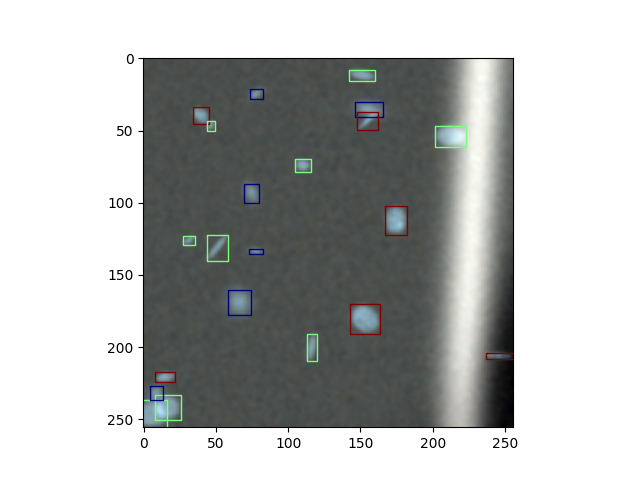

In [4]:
from yolo_help import bbox_to_rectangles, imshow

I,bbox,cl = groundtruth[0]
fig,ax = plt.subplots()
imshow(I,ax,cmap='gray')
polys = bbox_to_rectangles(bbox,fc='none')
polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
ax.add_collection(polys)

# The YOLO Model

### Variable Input Layer Example

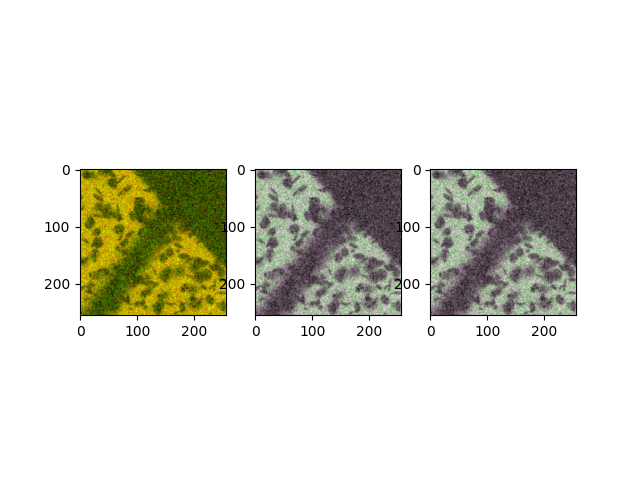

In [5]:
from yolo_help import VariableInputConv2d


layer = VariableInputConv2d(3)
fig,ax = plt.subplots(1,3)
I,bbox,cls = groundtruth[0]
imshow(I,ax[0])

r = torch.randperm(I.shape[0])
out1 = layer(torch.tensor(I,dtype=dtype)[None]).clone().detach()[0]
out2 = layer(torch.tensor(I,dtype=dtype)[r][None]).clone().detach()[0] 
imshow(out1,ax[1])
imshow(out2,ax[2])
# note the order of components doesn't matter

### Initalize a neural network following the YOLO framework

In [6]:
from yolo_help import Net

net = Net()

### Visualize example output from model

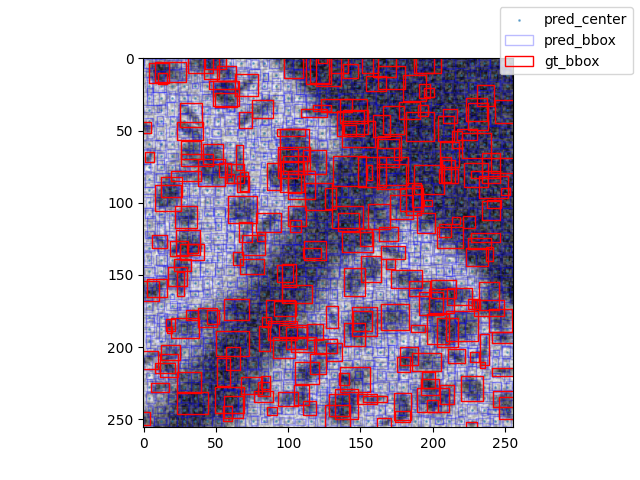

In [7]:
from yolo_help import convert_data

out = net(torch.tensor(I[None],dtype=dtype))
B = net.B
stride = net.stride

bboxes,data = convert_data(out,B,stride)

fig,ax = plt.subplots()
x = torch.arange(out.shape[-1])*stride + (stride-1)/2
y = torch.arange(out.shape[-2])*stride + (stride-1)/2
YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)
ax.imshow(I[0],cmap='gray')
ax.scatter(YX[1].ravel(),YX[0].ravel(),s=1,alpha=0.5)
x = bboxes[...,0]
y = bboxes[...,1]
w = bboxes[...,2]
h = bboxes[...,3]
c = data[...,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='b',alpha=c.clone().detach()*0.5)
ax.add_collection(predicted_rectangles,)

true_rectangles = bbox_to_rectangles(bbox,fc='none',ec='r')
ax.add_collection(true_rectangles,)
fig.legend(['pred_center','pred_bbox','gt_bbox'])
fig.canvas.draw()

### Add predicted bounding boxes to above figure

In [8]:
from yolo_help import get_assignment_inds


# transform the true bounding boxes
# to do this first we need an assignment to a given cell
shape = out.shape
B = net.B

assignment_inds,ious = get_assignment_inds(bboxes,bbox,shape,stride,B)
bboxes_assigned = bboxes[assignment_inds]
x = bboxes_assigned[...,0]
y = bboxes_assigned[...,1]
w = bboxes_assigned[...,2]
h = bboxes_assigned[...,3]
c = data[assignment_inds,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='g',alpha=c.clone().detach())
ax.add_collection(predicted_rectangles,)

# Model Training

Loaded predefined model from /home/abenneck/Desktop/yolo_model/examples/outputs/models/nepochs_9854/modelsave.pt
Starting epoch 0
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 

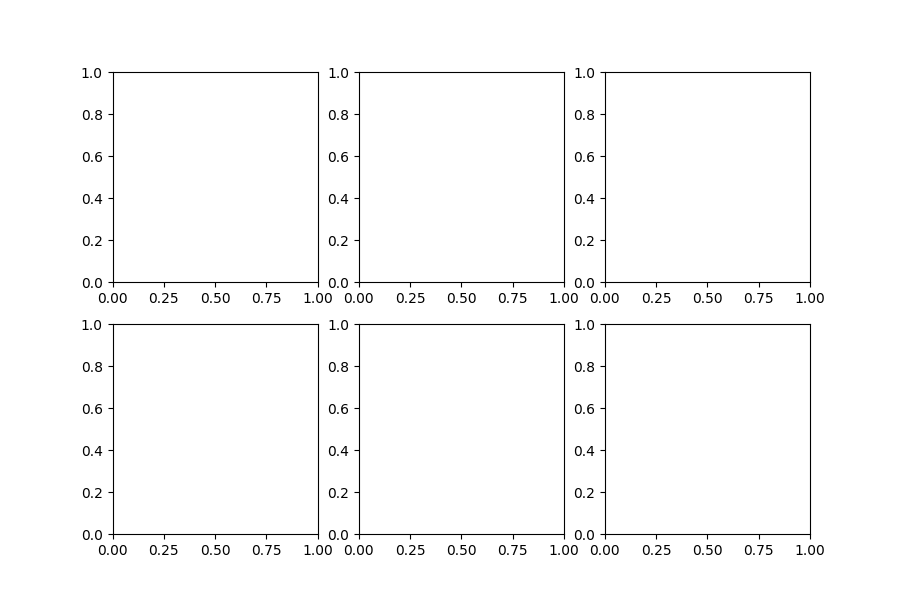

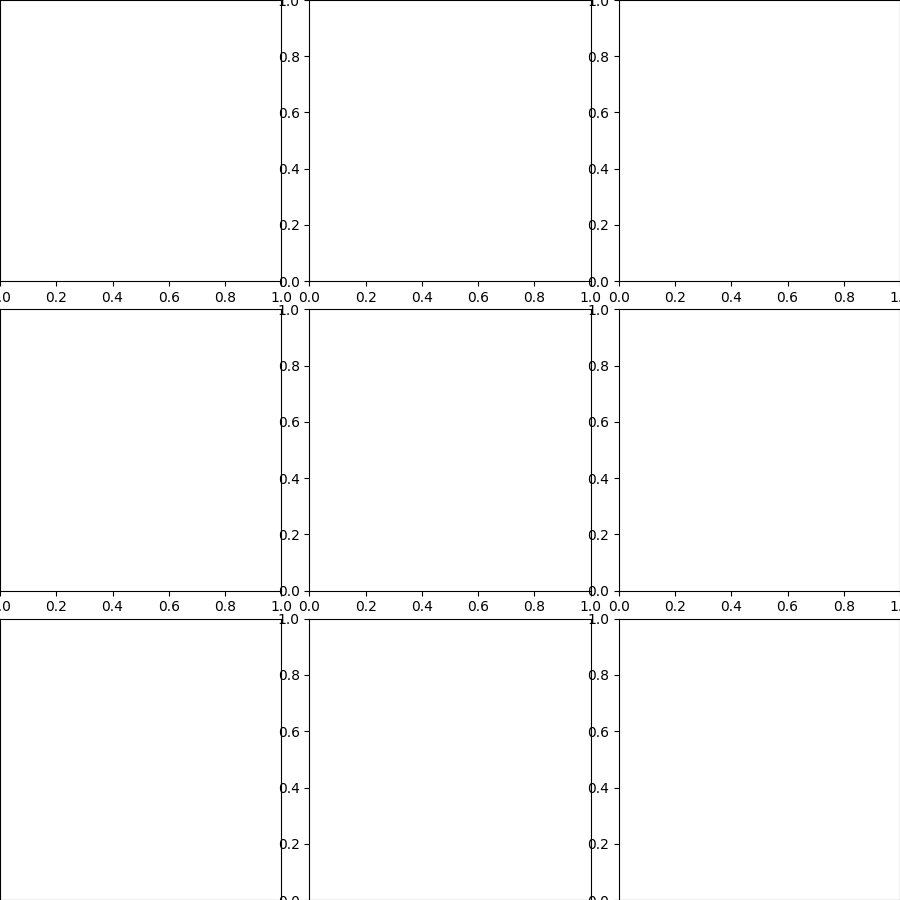

In [13]:
from yolo_help import train_yolo_model

nepochs = 9854
lr = 1e-4
cls_loss = torch.nn.CrossEntropyLoss(reduction='sum')
resume = True # if True, will load a saved model

modelname = 'modelsave.pt'
optimizername = 'optimizersave.pt'
lossname = 'loss.pt'
outdir_model = os.path.join(cwd,'outputs','models',f'nepochs_{nepochs}')

net = train_yolo_model(nepochs, lr, cls_loss, outdir_model, modelname, optimizername, lossname, verbose=True, resume=resume)

# Post-Processing

### Filter candidate bboxes (best_bbox_per_cell + NMS)

In [16]:
from yolo_help import get_best_bounding_box_per_cell
from yolo_post_help import NMS, remove_low_conf_bboxes

def filter_model_outputs(outdir, net, nms_filter = False):
    if not os.path.exists(outdir):
        print(f'Making new directory {outdir}')
        os.makedirs(outdir)
        
    if os.path.exists(os.path.join(outdir, 'all_gt_bbox.pkl')):
        # Save the gt_bbox, pred_bbox, and pred_score info for downstream analysis
        with open(os.path.join(outdir,'all_gt_bbox.pkl'),'rb') as f:
            all_gt_bbox = pickle.load(f)
        with open(os.path.join(outdir,'all_pred_bbox.pkl'),'rb') as f:
            all_pred_bbox = pickle.load(f)
        with open(os.path.join(outdir,'all_scores.pkl'),'rb') as f:
            all_scores = pickle.load(f)
        with open(os.path.join(outdir,'all_images.pkl'),'rb') as f:
            all_images = pickle.load(f)
        print(f'Loaded 4 files from {outdir}')
    else:
        all_pred_bbox = []
        all_scores = []
        all_gt_bbox = []
        all_images = []
        nimages_pq = 10

        groundtruth = GroundTruthDataset(reproducible = True)
        for i, gt in enumerate(groundtruth):
            # Quantify the model's performance against 'nimages_pq' simulated gt images
            if i >= nimages_pq:
                break
                
            # Initialize gt objects (bbox: [cx, cy, w, h, conf])
            I,bbox,cls = gt
            print(f'=== Starting groundtruth[{i}] ({len(bbox)} bboxes) ===')
        
            # Get model outputs for the ith image in the gt dataset
            out = net(torch.tensor(I,dtype=dtype)[None])
            bboxes,data = convert_data(out,net.B,net.stride)
            scores = data[:,-1]
            print(f'{len(bboxes)} bboxes output from model')
            
            # Reduces # of guesses by factor of 2
            start = time.time()
            bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores.clone().detach(),net.B)
            print(f'{len(bboxes_)} bboxes after getting best bbox per cell; Finished in {time.time() - start:.2f}s')
        
            # Remove bounding boxes below some conf threshold
            start = time.time()
            bboxes_, scores_ = remove_low_conf_bboxes(bboxes_, scores_)
            print(f'{len(bboxes_)} bboxes after removing low conf bboxes; Finished in {time.time() - start:.2f}s')
            
            # Perform NMS on filtered guesses (Reduce by a factor of ~2
            if nms_filter:
                start = time.time()
                bboxes_,scores_ = NMS(bboxes_, scores_, nms_threshold = 0.9)
                print(f'{len(bboxes_)} bboxes after NMS; Finished in {time.time() - start:.2f}s\n')
            
            # Append outputs from current image to all outputs for downstream performance quantification and visualization
            all_gt_bbox.append(bbox)
            all_pred_bbox.append(bboxes_)
            all_scores.append(scores_)
            all_images.append(I)
    
        # Save the gt_bbox, pred_bbox, and pred_score info for downstream analysis
        with open(os.path.join(outdir,'all_gt_bbox.pkl'),'wb') as f:
            pickle.dump(all_gt_bbox,f)
        with open(os.path.join(outdir,'all_pred_bbox.pkl'),'wb') as f:
            pickle.dump(all_pred_bbox,f)
        with open(os.path.join(outdir,'all_scores.pkl'),'wb') as f:
            pickle.dump(all_scores,f)
        with open(os.path.join(outdir,'all_images.pkl'),'wb') as f:
            pickle.dump(all_images,f)
        print(f'Saved output .pkl files to {outdir}')

    return all_pred_bbox, all_scores, all_gt_bbox, all_images

# Load filtered outputs, or generate new ones if none exist in outdir
outdir_data = os.path.join(cwd,'outputs','data',f'nepochs_{nepochs}')
all_pred_bbox, all_scores, all_gt_bbox, all_images = filter_model_outputs(outdir_data, net)

=== Starting groundtruth[0] (193 bboxes) ===
2048 bboxes output from model
1024 bboxes after getting best bbox per cell; Finished in 0.00s
318 bboxes after removing low conf bboxes; Finished in 0.01s
=== Starting groundtruth[1] (204 bboxes) ===
2048 bboxes output from model
1024 bboxes after getting best bbox per cell; Finished in 0.00s
297 bboxes after removing low conf bboxes; Finished in 0.02s
=== Starting groundtruth[2] (73 bboxes) ===
2048 bboxes output from model
1024 bboxes after getting best bbox per cell; Finished in 0.00s
92 bboxes after removing low conf bboxes; Finished in 0.01s
=== Starting groundtruth[3] (278 bboxes) ===
2048 bboxes output from model
1024 bboxes after getting best bbox per cell; Finished in 0.00s
320 bboxes after removing low conf bboxes; Finished in 0.01s
=== Starting groundtruth[4] (307 bboxes) ===
2048 bboxes output from model
1024 bboxes after getting best bbox per cell; Finished in 0.00s
350 bboxes after removing low conf bboxes; Finished in 0.01s
==

### Compare GT bounding boxes with filtered estimated bounding boxes

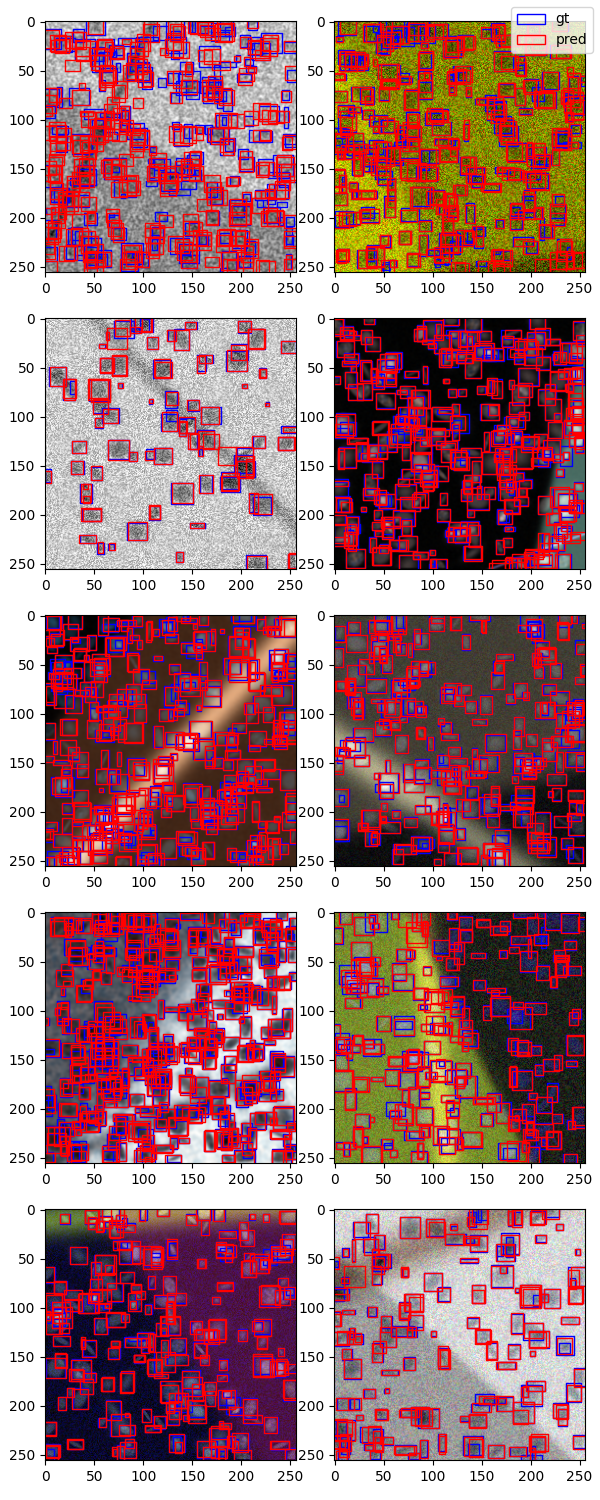

In [17]:
nrow = 5
ncol = 2
fig, axs = plt.subplots(nrow, ncol, layout = 'tight')
i,j = 0,0

for idx, I in enumerate(all_images):
    pred_bb = all_pred_bbox[idx]
    pred_s = all_scores[idx]
    gt_bb = all_gt_bbox[idx]

    imshow(I, axs[i,j], cmap = 'gray')
    gt_polys = bbox_to_rectangles(np.asarray(gt_bb),fc='none')
    gt_polys.set_edgecolor('blue')
    axs[i,j].add_collection(gt_polys)
    
    # imshow(I,axs[i,j],cmap='gray')
    pred_polys = bbox_to_rectangles(np.asarray(pred_bb),fc='none')
    pred_polys.set_edgecolor('red')
    axs[i,j].add_collection(pred_polys)

    j += 1

    if j > ncol - 1:
        j = 0
        i += 1

fig.legend(['gt','pred'])
fig.set_size_inches(ncol*3,nrow*3)
plt.show()

## PR Curve Generation

In [ ]:
import importlib as imp
import yolo_post_help
imp.reload(yolo_post_help)
from yolo_post_help import compute_pr_curves, plot_pr_curves, get_mAP

out = compute_pr_curves(all_gt_bbox, all_pred_bbox, all_scores, outdir_data, verbose = True)
fig, axs = plot_pr_curves(out)
fig, axs = plot_pr_curves(out, condense = False)
mAP = get_mAP(out)
print(f'mAP: {mAP}')

# TODO: Only compute (p,r) if there is a score below conf_thresh. Otherwise, all tp/fp/fn labels remain the same (Should save <10min on first 10)

===== Starting iou 0.5 =====
Starting conf 0.01
Finished images 1:2 / 10 in 20.38s
Finished images 3:4 / 10 in 21.27s
Finished images 5:6 / 10 in 24.19s
Finished images 7:8 / 10 in 9.78s
1784 + 341 = 2125 ?= 2125
(tp, fp, fn) = (1784, 901, 341) across 10 images
Finished iter in 78.18s

Starting conf 0.02
Finished images 1:2 / 10 in 20.27s
Finished images 3:4 / 10 in 21.18s
Finished images 5:6 / 10 in 24.26s
Finished images 7:8 / 10 in 9.89s
1784 + 341 = 2125 ?= 2125
(tp, fp, fn) = (1784, 901, 341) across 10 images
Finished iter in 78.22s

Starting conf 0.03
Finished images 1:2 / 10 in 20.42s
Finished images 3:4 / 10 in 21.20s
Finished images 5:6 / 10 in 24.20s
Finished images 7:8 / 10 in 9.74s
1784 + 341 = 2125 ?= 2125
(tp, fp, fn) = (1784, 901, 341) across 10 images
Finished iter in 78.16s

Starting conf 0.04
Finished images 1:2 / 10 in 20.37s
Finished images 3:4 / 10 in 21.32s
Finished images 5:6 / 10 in 24.29s
Finished images 7:8 / 10 in 9.76s
1784 + 341 = 2125 ?= 2125
(tp, fp, fn) 

In [ ]:
total = 0
for i, gt_bb in enumerate(all_pred_bbox):
    total += len(gt_bb)
    print(i,':',len(gt_bb))
print(total)